
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.17?urlpath=lab/tree/extended_source_spectral_analysis.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[extended_source_spectral_analysis.ipynb](../_static/notebooks/extended_source_spectral_analysis.ipynb) |
[extended_source_spectral_analysis.py](../_static/notebooks/extended_source_spectral_analysis.py)
</div>


# Spectral analysis of extended sources

## Prerequisites:

- Understanding of spectral analysis techniques in classical Cherenkov astronomy.
- Understanding of how the spectrum and cube extraction API works, please refer to the [spectrum extraction notebook](spectrum_analysis.ipynb) and to the [3D analysis notebook](analysis_2.ipynb).

## Context

Many VHE sources in the Galaxy are extended. Studying them with a 1D spectral analysis is more complex than studying point sources. 
One often has to use complex (i.e. non circular) regions and more importantly, one has to take into account the fact that the instrument response is non uniform over the selectred region.
A typical example is given by the supernova remnant RX J1713-3935 which is nearly 1 degree in diameter. See the [following article](https://ui.adsabs.harvard.edu/abs/2018A%26A...612A...6H/abstract).

**Objective: Measure the spectrum of RX J1713-3945 in a 1 degree region fully enclosing it.**

## Proposed approach:

We have seen in the general presentation of the spectrum extraction for point sources, see [the corresponding notebook](spectrum_analysis.ipynb), that Gammapy uses specific datasets makers to first produce reduced spectral data and then to extract OFF measurements with reflected background techniques: the `~gammapy.makers.SpectrumDatasetMaker` and the `~gammapy.makers.ReflectedRegionsBackgroundMaker`. The former simply computes the reduced IRF at the center of the ON region (assumed to be circular).

This is no longer valid for extended sources. To be able to compute average responses in the ON region, Gammapy relies on the creation of a cube enclosing it (i.e. a `~gammapy.datasets.MapDataset`) which can be reduced to a simple spectrum (i.e. a `~gammapy.datasets.SpectrumDataset`). We can then proceed with the OFF extraction as the standard point source case.

In summary, we have to:

- Define an ON region (a `~regions.SkyRegion`) fully enclosing the source we want to study.
- Define a geometry that fully contains the region and that covers the required energy range (beware in particular, the true energy range).  
- Create the necessary makers : 
    - the map dataset maker : `~gammapy.makers.MapDatasetMaker`
    - the OFF background maker, here a `~gammapy.makers.ReflectedRegionsBackgroundMaker`
    - and usually the safe range maker : `~gammapy.makers.SafeRangeMaker`
- Perform the data reduction loop. And for every observation:
    - Produce a map dataset and squeeze it to a spectrum dataset with `~gammapy.datasets.MapDataset.to_spectrum_dataset(on_region)`
    - Extract the OFF data to produce a `~gammapy.datasets.SpectrumDatasetOnOff` and compute a safe range for it.
    - Stack or store the resulting spectrum dataset.
- Finally proceed with model fitting on the dataset as usual.

Here, we will use the RX J1713-3945 observations from the H.E.S.S. first public test data release. The tutorial is implemented with the intermediate level API.

## Setup 

As usual, we'll start with some general imports...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.data import DataStore
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
)
from gammapy.datasets import Datasets, MapDataset
from gammapy.makers import (
    SafeMaskMaker,
    MapDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)

## Select the data

We first set the datastore and retrieve a few observations from our source.

In [3]:
datastore = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
obs_ids = [20326, 20327, 20349, 20350, 20396, 20397]
# In case you want to use all RX J1713 data in the HESS DR1
# other_ids=[20421, 20422, 20517, 20518, 20519, 20521, 20898, 20899, 20900]

observations = datastore.get_observations(obs_ids)

## Prepare the datasets creation

### Select the ON region

Here we take a simple 1 degree circular region because it fits well with the morphology of RX J1713-3945. More complex regions could be used e.g. `~regions.EllipseSkyRegion` or `~regions.RectangleSkyRegion`.

In [4]:
target_position = SkyCoord(347.3, -0.5, unit="deg", frame="galactic")
radius = Angle("0.5 deg")
on_region = CircleSkyRegion(target_position, radius)

### Define the geometries

This part is especially important. 
- We have to define first energy axes. They define the axes of the resulting `~gammapy.datasets.SpectrumDatasetOnOff`. In particular, we have to be careful to the true energy axis: it has to cover a larger range than the reconstructed energy one.
- Then we define the geometry itself. It does not need to be very finely binned and should enclose all the ON region. To limit CPU and memory usage, one should avoid using a much larger region.

In [5]:
# The binning of the final spectrum is defined here.
energy_axis = MapAxis.from_energy_bounds(0.3, 40.0, 10, unit="TeV")

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, 30, unit="TeV", name="energy_true"
)

# Here we use 1.5 degree which is slightly larger than needed.
geom = WcsGeom.create(
    skydir=target_position,
    binsz=0.04,
    width=(1.5, 1.5),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

### Create the makers

First we instantiate the target `~gammapy.datasets.MapDataset`.  

In [6]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="rxj-stacked"
)

Now we create its associated maker. Here we need to produce, counts, exposure and edisp (energy dispersion) entries. PSF and IRF background are not needed, therefore we don't compute them.

In [7]:
maker = MapDatasetMaker(selection=["counts", "exposure", "edisp"])

Now we create the OFF background maker for the spectra. If we have an exclusion region, we have to pass it here. We also define the safe range maker.

In [8]:
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_maker = SafeMaskMaker(
    methods=["aeff-default", "aeff-max"], aeff_percent=10
)

## Perform the data reduction loop.

We can now run over selected observations. For each of them, we:
- create the map dataset and stack it on our target dataset.
- squeeze the map dataset to a spectral dataset in the ON region
- Compute the OFF and create a `~gammapy.datasets.SpectrumDatasetOnOff` object
- Run the safe mask maker on it
- Add the `~gammapy.datasets.SpectrumDatasetOnOff` to the list.

In [9]:
%%time
spectrum_datasets = []

for obs in observations:
    # A MapDataset is filled in this geometry
    dataset = maker.run(stacked, obs)
    # To make images, the resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

    # Extract 1D spectrum
    spectrum_dataset = dataset.to_spectrum_dataset(on_region)
    # Compute OFF
    spectrum_dataset = bkg_maker.run(spectrum_dataset, obs)
    # Define safe mask
    spectrum_dataset = safe_mask_maker.run(spectrum_dataset, obs)
    # Append dataset to the list
    spectrum_datasets.append(spectrum_dataset)

datasets = Datasets(spectrum_datasets)

CPU times: user 2.83 s, sys: 168 ms, total: 3 s
Wall time: 3.06 s


## Explore the results

First let's look at the data to see if our region is correct.
We plot it over the excess. To do so we convert it to a pixel region using the WCS information stored on the geom.

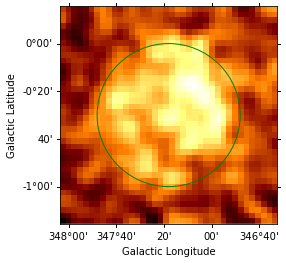

In [10]:
stacked.counts.sum_over_axes().smooth(width="0.05 deg").plot()
on_region.to_pixel(stacked.counts.geom.wcs).plot()

We now turn to the spectral datasets. We can peek at their content:

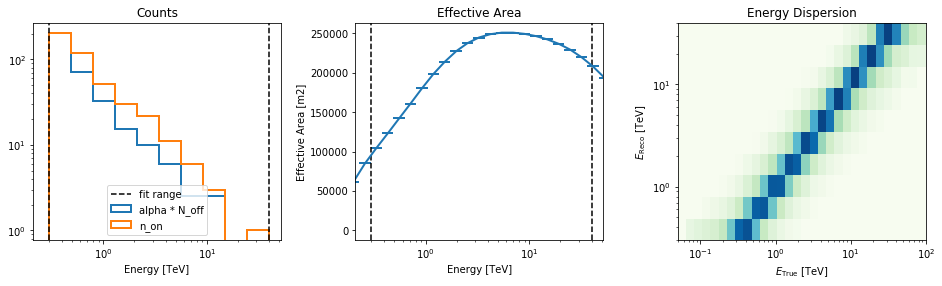

In [11]:
datasets[0].peek()

### Cumulative excess and signficance

Finally, we can look at cumulative significance and number of excesses. This is done with the `info_table` method of `~gammapy.datasets.Datasets`. 

In [12]:
info_table = datasets.info_table(cumulative=True)

In [13]:
info_table

name,livetime,n_on,background,excess,significance [1],background_rate,gamma_rate,a_on,n_off,a_off,alpha
,s,,,,,1 / s,1 / s,,,,
str7,float64,float32,float64,float64,float64,float64,float64,float64,float32,float64,float64
stacked,1683.0,450.0,343.5,106.5,4.405517626186096,0.20409982174688057,0.06327985739750445,1.0,687.0,2.0,0.5
stacked,3366.0,845.0,670.5,174.5,5.215405763158092,0.19919786096256684,0.05184194890077243,1.0,1341.0,2.0,0.5
stacked,5048.0,1288.0,983.0,305.0,7.457874883123557,0.19473058637083993,0.06041996830427892,1.0,1966.0,2.0,0.5
stacked,6730.0,1725.0,1341.0,384.0,8.075257505628382,0.19925705794947995,0.05705794947994056,1.0,2682.0,2.0,0.5
stacked,8413.0,2198.0,1653.0001220703125,545.0000610351562,10.230952957422629,0.1964816500737326,0.06478070379592966,1.0,3618.0,2.1784777641296387,0.4590361416339874
stacked,10095.0,2626.0,2001.5001220703125,624.5000610351562,10.668056021769223,0.1982664806409423,0.0618623141193815,1.0,4315.0,2.1466150283813477,0.46584972739219666


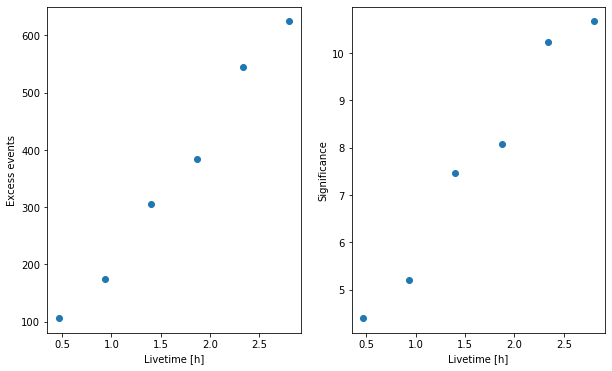

In [14]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(121)
ax.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)
plt.xlabel("Livetime [h]")
plt.ylabel("Excess events")

ax = fig.add_subplot(122)
ax.plot(
    info_table["livetime"].to("h"),
    info_table["significance"],
    marker="o",
    ls="none",
)
plt.xlabel("Livetime [h]")
plt.ylabel("Significance");

## Perform spectral model fitting

Here we perform a joint fit. 

We first create the model, here a simple powerlaw, and assign it to every dataset in the `~gammapy.datasets.Datasets`.

In [15]:
spectral_model = PowerLawSpectralModel(
    index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV
)
model = SkyModel(spectral_model=spectral_model)

for dataset in datasets:
    dataset.models = model

Now we can run the fit

In [16]:
fit_joint = Fit(datasets)
result_joint = fit_joint.run()
print(result_joint)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 43
	total stat : 73.21



### Explore the fit results

First the fitted parameters values and their errors.

In [17]:
result_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
index,2.101e+00,,nan,nan,False,6.741e-02
amplitude,1.286e-11,cm-2 s-1 TeV-1,nan,nan,False,1.032e-12
reference,1.000e+00,TeV,nan,nan,True,0.000e+00


Then plot the fit result to compare measured and expected counts. Rather than plotting them for each individual dataset, we stack all datasets and plot the fit result on the result.

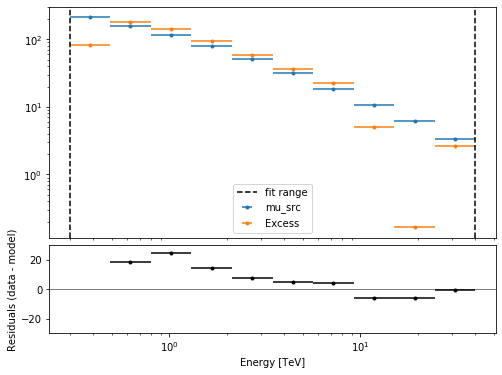

In [18]:
plt.figure(figsize=(8, 6))
# First stack them all
reduced = datasets.stack_reduce()
# Assign the fitted model
reduced.models = model
# Plot the result
reduced.plot_fit();